<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Create_NR_Geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Start
## The following code shows the main function that is used to reduce a complex cell.

complex_cell  # The model cell

synapses_list # A list of all synapse on this cell

netcon_list   # A list of all netcons for the synapses on the cell

import neuron_reduce

reduced_cell, synapses_list, netcons_list =  neuron_reduce.subtree_reductor(complex_cell, synapses_list, netcons_list)

# Detailed Example
## Example copied from github

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/orena1/neuron_reduce.git

fatal: destination path 'neuron_reduce' already exists and is not an empty directory.


In [4]:
# Go to example folder
%cd neuron_reduce 
%cd example
# compile the mod files
!nrnivmodl mod

/content/neuron_reduce
/content/neuron_reduce/example
/content/neuron_reduce/example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


##Functions in this notebook

In [5]:
import pandas as pd
def generate_stylized_geometry(cell,savename):
  df = pd.DataFrame()
  ids=[]
  names=[]
  types=[]
  pids=[]
  axials=[]
  nbranchs=[]
  Ls=[]
  Rs=[]
  angs=[]

  id=0
  for sec in cell.all:
    # print(dir(sec))
    name=sec.name()
    names.append(name)
    ids.append(names.index(name))
    _,sec_type_withinteger=name.split('.')
    sec_type,_=sec_type_withinteger.split('[')
    types.append(sec_type)
    pseg = sec.parentseg()
    if pseg == None:
      pids.append(None)
    else:
      psec=pseg.sec
      pids.append(names.index(psec.name()))
    axials.append('TRUE')
    nbranchs.append(1)
    Ls.append(sec.L)
    # print(dir(sec))
    Rs.append(sec.diam/2) # may need to compute single radius for each section
    angs.append(180)

  # print(len(ids))
  # print(len(names))
  # print(len(types))
  # print(len(pids))
  # print(len(axials))
  # print(len(nbranchs))
  # print(len(Ls))
  # print(len(Rs))
  # print(angs)
  df["id"] = ids
  df["name"] = names
  df["pid"] = pids
  df["axial"] = axials
  df["type"] = types
  df["nbranch"] = nbranchs
  df["L"] = Ls
  df["R"] = Rs
  df["ang"] = angs
  df.to_csv(savename)

In [6]:
def returnSegmentValues(section):
    ##
    
    #Section naming
    #Set impedance measurement location and frequency
    name=section.name()
    # Get section 3d coordinates and put in numpy array
    n3d = section.n3d()
    x3d = np.empty(n3d)
    y3d = np.empty(n3d)
    z3d = np.empty(n3d)
    L = np.empty(n3d)
    for i in range(n3d):
        x3d[i]=section.x3d(i)
        y3d[i]=section.y3d(i)
        z3d[i]=section.z3d(i)

    # Compute length of each 3d segment
    for i in range(n3d):
        if i==0:
            L[i]=0
        else:
            L[i]=np.sqrt((x3d[i]-x3d[i-1])**2 + (y3d[i]-y3d[i-1])**2 + (z3d[i]-z3d[i-1])**2)

    # Get cumulative length of 3d segments
    cumLength = np.cumsum(L)
    N = section.nseg
    # Now upsample coordinates to segment locations
    xCoord = np.empty(N)
    yCoord = np.empty(N)
    zCoord = np.empty(N)


    if N > 1:
      dx = section.L / (N-1)
    else:
      dx = section.L

    #print(str(section))
    if "axon" in name:
      xCoord=[np.NaN]
      yCoord=[np.NaN]
      zCoord=[np.NaN]
    else:
      for n in range(N):

        if n==(N-1):
            xCoord[n]=x3d[-1]
            yCoord[n]=y3d[-1]
            zCoord[n]=z3d[-1]
        else:
            cIdxStart = np.where(n*dx >= cumLength)[0][-1] # which idx of 3d segments are we starting at
            cDistFrom3dStart = n*dx - cumLength[cIdxStart] # how far along that segment is this upsampled coordinate
            cFraction3dLength = cDistFrom3dStart / L[cIdxStart+1] # what's the fractional distance along this 3d segment
            # compute x and y positions
            xCoord[n] = x3d[cIdxStart] + cFraction3dLength*(x3d[cIdxStart+1] - x3d[cIdxStart])
            yCoord[n] = y3d[cIdxStart] + cFraction3dLength*(y3d[cIdxStart+1] - y3d[cIdxStart])
            zCoord[n] = z3d[cIdxStart] + cFraction3dLength*(z3d[cIdxStart+1] - z3d[cIdxStart])
              
    return xCoord, yCoord, zCoord

In [7]:
def measure_input_impedance_of_subtree(subtree_root_section, frequency):
    '''measures the input impedance of the subtree with the given root section
    (at the "0" tip, the soma-proximal end),
    returns the Impedance hoc object and the input impedance as a complex value
    '''

    imp_obj = h.Impedance()
    CLOSE_TO_SOMA_EDGE = 0
    # sets origin for impedance calculations (soma-proximal end of root section)
    imp_obj.loc(CLOSE_TO_SOMA_EDGE, sec=subtree_root_section)

    # computes transfer impedance from every segment in the model in relation
    # to the origin location above
    imp_obj.compute(frequency + 1 / 9e9, 0)

    # in Ohms (impedance measured at soma-proximal end of root section)
    root_input_impedance = imp_obj.input(CLOSE_TO_SOMA_EDGE, sec=subtree_root_section) * 1000000
    root_input_phase = imp_obj.input_phase(CLOSE_TO_SOMA_EDGE, sec=subtree_root_section)
    # creates a complex impedance value out of the given polar coordinates
    root_input_impedance = cmath.rect(root_input_impedance, root_input_phase)
    return imp_obj, root_input_impedance

In [8]:
def make_seg_df(cell,savename="Segments.csv"):
    frequency=0
    # seg_locs = cell.morphology.seg_coords['p05']
    # px = seg_locs[0]
    # py = seg_locs[1]
    # pz = seg_locs[2]
    df = pd.DataFrame()
    k = 0
    j = 0
    lens = []
    seg_lens = []
    diams = []
    segdiams = []
    bmtk_ids = []
    seg_ids = []
    sec_ids = []
    full_names = []
    xs = []
    parts = []
    distances = []
    try:h.distance(sec=cell.hobj.soma[0])
    except:h.distance(sec=cell.soma[0])
    nsegs=[]
    RAs=[]
    Parentx=[]
    passive_elec_distances = []
    active_elec_distances = []
    passive = h.Impedance()
    try:passive.loc(cell.hobj.soma[0](0.5))
    except:passive.loc(cell.soma[0](0.5))
    passive.compute(frequency + 1 / 9e9, 0)
    active = h.Impedance()
    try:active.loc(cell.hobj.soma[0](0.5))
    except:active.loc(cell.soma[0](0.5))
    active.compute(frequency + 1 / 9e9, 1)
#############################################################
    
    psegids=[]
    segments=[]
    sections=[]
    all_seg_x_coords=[]
    all_seg_y_coords=[]
    all_seg_z_coords=[]
    section_names_by_seg=[]
#    segments=cell.hobj.segments
#    for i in range(len(cell.hobj.segments)):
#      pseg = segments[i].sec.parentseg()
#      psec=pseg.sec
#      nseg = psec.nseg
#      idx = int(np.floor(pseg.x * nseg))
#      if pseg.x == 1.:
#        idx -= 1
#      psegid=segments.index(psec((i + .5) / nseg))
#      psegids.append(psegid)
################################################################
    try: section_obj_list=cell.hobj.all
    except: section_obj_list=cell.all
    for sec in section_obj_list:
        xCoords,yCoords,zCoords=returnSegmentValues(sec) # get 3d coordinates for this section
        for i,seg in enumerate(sec):
            all_seg_x_coords.append(xCoords[i])
            all_seg_y_coords.append(yCoords[i])
            all_seg_z_coords.append(zCoords[i])
            lens.append(seg.sec.L)
            seg_lens.append(seg.sec.L/seg.sec.nseg)
            diams.append(seg.sec.diam)
            segdiams.append(seg.diam)
            distances.append(h.distance(seg))
            bmtk_ids.append(k)
            seg_ids.append(j)
            xs.append(seg.x)
            fullsecname = sec.name()
            sec_ids.append(int(fullsecname.split("[")[2].split("]")[0]))
            sec_type = fullsecname.split(".")[1][:4]
            nsegs.append(seg.sec.nseg)
            RAs.append(seg.sec.Ra)
            parts.append(sec_type)
            full_names.append(str(seg))
            passive_elec_distances.append(passive.ratio(seg))
            active_elec_distances.append(active.ratio(seg))
            section_names_by_seg.append(fullsecname)
            #if seg.sec.parentseg() is not None:
              #get parentseg coordinates or something to identify parentseg by
            j += 1
            segments.append(seg)
        k+=1
        sections.append(sec)
    #print(segments)
    for i in range(len(segments)): #calculate parentseg id using seg index on section
      idx = int(np.floor(segments[i].x * segments[i].sec.nseg)) #get seg index on section
      #case where segment is not first segment on section:
      if idx != 0: #if the segment is not the first on the section then the parent segment is the previous segment index
        psegid=i-1 #set parent segment id to the previous segment index
        psegids.append(psegid)
      #case where segment is first segment on section:
      else:
        pseg = segments[i].sec.parentseg()
        if pseg == None:
          psegids.append(None)
        else:
          psec=pseg.sec
          nseg = psec.nseg
          pidx = int(np.floor(pseg.x * nseg)) #get parent seg index on section
          if pseg.x == 1.:
            pidx -= 1
          psegid=segments.index(psec((pidx + .5) / nseg)) #find the segment id of the parent seg by comparing with segment list after calculating the parent seg's section(x)
          psegids.append(psegid)


    df["segmentID"] = seg_ids
    df["BMTK ID"] = bmtk_ids
    df["Seg_L"] = seg_lens
    df["Seg_diam"] = segdiams
    df["X"] = xs
    df["Type"] = parts
    df["Sec ID"] = sec_ids
    df["Distance"] = distances
    df["Section_L"] = lens
    df["Section_diam"] = diams
    df["Section_nseg"] = nsegs
    df["Section_Ra"] = RAs
    df["Coord X"] = all_seg_x_coords
    df["Coord Y"] = all_seg_y_coords
    df["Coord Z"] = all_seg_z_coords
    df["ParentSegID"] = psegids
    df["Passive ElecDist"] = passive_elec_distances
    df["Active ElecDist"] = active_elec_distances
    df["Section Name"] = section_names_by_seg


    df.to_csv(savename, index=False)

In [9]:
def make_reduced_seg_df(cell,savename="Segments.csv"):
    frequency=0
    # seg_locs = cell.morphology.seg_coords['p05']
    # px = seg_locs[0]
    # py = seg_locs[1]
    # pz = seg_locs[2]
    df = pd.DataFrame()
    k = 0
    j = 0
    lens = []
    seg_lens = []
    diams = []
    segdiams = []
    bmtk_ids = []
    seg_ids = []
    sec_ids = []
    full_names = []
    xs = []
    parts = []
    distances = []
    try:h.distance(sec=cell.soma)
    except:h.distance(sec=cell.soma[0])
    nsegs=[]
    RAs=[]
    Parentx=[]
    passive_elec_distances = []
    active_elec_distances = []
    passive = h.Impedance()
    try:passive.loc(cell.hobj.soma[0](0.5))
    except:passive.loc(cell.soma[0](0.5))
    passive.compute(frequency + 1 / 9e9, 0)
    active = h.Impedance()
    try:active.loc(cell.hobj.soma[0](0.5))
    except:active.loc(cell.soma[0](0.5))
    active.compute(frequency + 1 / 9e9, 1)
#############################################################
    
    psegids=[]
    segments=[]
    sections=[]
    all_seg_x_coords=[]
    all_seg_y_coords=[]
    all_seg_z_coords=[]
    section_names_by_seg=[]
#    segments=cell.hobj.segments
#    for i in range(len(cell.hobj.segments)):
#      pseg = segments[i].sec.parentseg()
#      psec=pseg.sec
#      nseg = psec.nseg
#      idx = int(np.floor(pseg.x * nseg))
#      if pseg.x == 1.:
#        idx -= 1
#      psegid=segments.index(psec((i + .5) / nseg))
#      psegids.append(psegid)
################################################################
    try: section_obj_list=cell.hoc_model.all
    except: section_obj_list=cell.all
    for sec in section_obj_list:
        # xCoords,yCoords,zCoords=returnSegmentValues(sec) # get 3d coordinates for this section
        for i,seg in enumerate(sec):
            # all_seg_x_coords.append(xCoords[i])
            # all_seg_y_coords.append(yCoords[i])
            # all_seg_z_coords.append(zCoords[i])
            lens.append(seg.sec.L)
            seg_lens.append(seg.sec.L/seg.sec.nseg)
            diams.append(seg.sec.diam)
            segdiams.append(seg.diam)
            distances.append(h.distance(seg))
            bmtk_ids.append(k)
            seg_ids.append(j)
            xs.append(seg.x)
            fullsecname = sec.name()
            sec_ids.append(int(fullsecname.split("[")[2].split("]")[0]))
            sec_type = fullsecname.split(".")[1][:4]
            nsegs.append(seg.sec.nseg)
            RAs.append(seg.sec.Ra)
            parts.append(sec_type)
            full_names.append(str(seg))
            passive_elec_distances.append(passive.ratio(seg))
            active_elec_distances.append(active.ratio(seg))
            section_names_by_seg.append(fullsecname)
            #if seg.sec.parentseg() is not None:
              #get parentseg coordinates or something to identify parentseg by
            j += 1
            segments.append(seg)
        k+=1
        sections.append(sec)
    #print(segments)
    for i in range(len(segments)): #calculate parentseg id using seg index on section
      idx = int(np.floor(segments[i].x * segments[i].sec.nseg)) #get seg index on section
      #case where segment is not first segment on section:
      if idx != 0: #if the segment is not the first on the section then the parent segment is the previous segment index
        psegid=i-1 #set parent segment id to the previous segment index
        psegids.append(psegid)
      #case where segment is first segment on section:
      else:
        pseg = segments[i].sec.parentseg()
        if pseg == None:
          psegids.append(None)
        else:
          psec=pseg.sec
          nseg = psec.nseg
          pidx = int(np.floor(pseg.x * nseg)) #get parent seg index on section
          if pseg.x == 1.:
            pidx -= 1
          try:psegid=segments.index(psec((pidx + .5) / nseg)) #find the segment id of the parent seg by comparing with segment list after calculating the parent seg's section(x)
          except: psegid="Segment not in segments"
          psegids.append(psegid)


    df["segmentID"] = seg_ids
    df["BMTK ID"] = bmtk_ids
    df["Seg_L"] = seg_lens
    df["Seg_diam"] = segdiams
    df["X"] = xs
    df["Type"] = parts
    df["Sec ID"] = sec_ids
    df["Distance"] = distances
    df["Section_L"] = lens
    df["Section_diam"] = diams
    df["Section_nseg"] = nsegs
    df["Section_Ra"] = RAs
    # df["Coord X"] = all_seg_x_coords
    # df["Coord Y"] = all_seg_y_coords
    # df["Coord Z"] = all_seg_z_coords
    df["ParentSegID"] = psegids
    df["Passive ElecDist"] = passive_elec_distances
    df["Active ElecDist"] = active_elec_distances
    df["Section Name"] = section_names_by_seg


    df.to_csv(savename, index=False)

In [10]:
class probe():
  def __init__(self,seg=None,sectionindex=None,sectionname=None,color=None,secRa=None,segdiam=None,segx=None,segdist=None,sectionL=None,sectionNseg=None,segL=None,parentseg=None,sectype=None,active_elec_dist=None,passive_elec_dist=None,XCoord=None,YCoord=None,ZCoord=None):
    self.seg=seg
    self.sectionindex=sectionindex
    self.sectionname=sectionname
    self.color=color
    self.XCoord=XCoord
    self.YCoord=YCoord
    self.ZCoord=ZCoord
    self.secRa=secRa
    self.segdiam=segdiam
    self.x=segx
    self.segdist=segdist
    self.secL=sectionL
    self.secnseg=sectionNseg
    self.segL=segL
    # self.seg_v=seg_v
    self.name='sec:'+str(self.sectionname)+str(self.sectionindex)+' seg:'+str(self.seg)
    self.adjprobes=[]
    self.parentprobe=[]
    self.childprobes=[]
    self.axialcurrents=[]
    self.parentaxialcurrent=[]
    self.childrenaxialcurrents=[]
    self.halfsegRa=.01*self.secRa*(self.secL/2/self.secnseg)/(np.pi*(self.segdiam/2)**2)
    self.parentseg=parentseg
    self.sectype=sectype
    self.passive_elec_dist=passive_elec_dist
    self.active_elec_dist=active_elec_dist

    # try:
    #   self.axial_current=[Record_Axial_Current(section,single_seg=True)]
    # except:
    #   print(section)

In [11]:
def generate_reduced_stylized_geometry(reduced_cell=None,complex_geometry_file='geom_complex.csv',savename='geom_reduced.csv'):
  '''
  builds reduced_geom.csv 
  using dendritic sections from neuron_reduce()'s reduced_cell object 
  and soma from complex cell
  '''

  complex_df = pd.read_csv(complex_geometry_file) #need to begin reduced_df with soma from complex_cell
  df = pd.DataFrame()
  ids=[complex_df['id'][0]]
  names=[complex_df['name'][0]]
  types=[complex_df['type'][0]]
  pids=[complex_df['pid'][0]]
  axials=[complex_df['axial'][0]]
  nbranchs=[complex_df['nbranch'][0]]
  Ls=[complex_df['L'][0]]
  Rs=[complex_df['R'][0]]
  angs=[complex_df['ang'][0]]

  for sec in reduced_cell.hoc_model.all:
    # print(dir(sec))
    name=sec.name()
    # print(name)
    names.append(name)
    ids.append(names.index(name))
    _,sec_type_withinteger=name.split('.')
    sec_type,_=sec_type_withinteger.split('[')
    types.append(sec_type)
    pseg = sec.parentseg()
    if pseg == None:
      pids.append(None)
    else:
      psec=pseg.sec
      px3d=psec.x3d
      pids.append(names.index(psec.name()))
    axials.append('TRUE')
    nbranchs.append(1)
    Ls.append(sec.L)
    # print(dir(sec))
    Rs.append(sec.diam/2) 

    if sec.n3d() != 0: # all reduced cell 3d coordinates are missin; need a fix for angles
      print(sec.n3d())
      first_x3d=sec.x3d(0)
      first_y3d=sec.y3d(0)
      first_z3d=sec.z3d(0)
      last_x3d=sec.x3d(sec.n3d()-1)
      last_y3d=sec.y3d(sec.n3d()-1)
      last_z3d=sec.z3d(sec.n3d()-1)

      pfirst_x3d=psec.x3d(0)
      pfirst_y3d=psec.y3d(0)
      pfirst_z3d=psec.z3d(0)
      plast_x3d=psec.x3d(psec.n3d()-1)
      plast_y3d=psec.y3d(psec.n3d()-1)
      plast_z3d=psec.z3d(psec.n3d()-1)
      print(first_x3d-plast_x3d)
      print(first_y3d-plast_y3d)
      print(first_z3d-plast_z3d)
    else:
      angs.append(None)

  # print(len(ids))
  # print(len(names))
  # print(len(types))
  # print(len(pids))
  # print(len(axials))
  # print(len(nbranchs))
  # print(len(Ls))
  # print(len(Rs))
  # print(angs)
  df["id"] = ids
  df["name"] = names
  df["L"] = pids
  df["axial"] = axials
  df["type"] = types
  df["nbranch"] = nbranchs
  df["L"] = Ls
  df["R"] = Rs
  df["ang"] = angs
  df.to_csv(savename)


##Define The Cell

In [12]:
#Run the code
from __future__ import division
from neuron import gui,h
import numpy as np
import neuron_reduce
import time
import matplotlib.pyplot as plt

#Create a L5_PC model
h.load_file('L5PCbiophys3.hoc')
h.load_file("import3d.hoc")
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

In [13]:
!git clone https://github.com/davidfague/Stylized-ReducedOrder-L5-Model.git
%cd Stylized-ReducedOrder-L5-Model
from stylized_module.recorder import Recorder
%cd ..

fatal: destination path 'Stylized-ReducedOrder-L5-Model' already exists and is not an empty directory.
/content/neuron_reduce/example/Stylized-ReducedOrder-L5-Model
/content/neuron_reduce/example


Add synapses to the cell

In [14]:
#Add synapses to the model
synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] + [i for j in map(list,list(complex_cell.basal)) for i in j]
len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
rnd = np.random.RandomState(10)
for i in range(10000):
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
    synapses_list.append(h.Exp2Syn(seg_for_synapse))
    if rnd.uniform()<0.85: # 85% synapses are excitatory
        e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
    else: #inhibitory case
        e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
    #set synaptic varibales
    synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
    #set netstim variables
    netstims_list.append(h.NetStim())
    netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
    #set random
    randoms_list.append(h.Random())
    randoms_list[i].Random123(i)
    randoms_list[i].negexp(1)
    netstims_list[i].noiseFromRandom(randoms_list[i])       
    #set netcon varibales 
    netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
    netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight

In [15]:
make_seg_df(complex_cell,"segments_complex.csv")

In [16]:
complex_segments_df=pd.read_csv("segments_complex.csv")

In [17]:
# complex_segments.head()

Need to find the branching point here; use segment_axial_currents notebook where I have done it before.

In [18]:
#Get Columns
segIDs=complex_segments_df['segmentID']

# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index() #not sure what this does
complex_segments_df['Sec ID'] = complex_segments_df['Sec ID'].astype(int)
complex_segments_df['X'] = complex_segments_df['X'].astype(float)
complex_segments_df['Elec_distanceQ'] = 'None'
AllSegXCoord=complex_segments_df['Coord X']
AllSegYCoord=complex_segments_df['Coord Y']
AllSegZCoord=complex_segments_df['Coord Z']
AllSegSec_ID=complex_segments_df['Sec ID']
AllSegSec_name=complex_segments_df['Type']
segLs=complex_segments_df["Seg_L"]
segxs=complex_segments_df["X"]
segdists=complex_segments_df["Distance"]
SegSecL=complex_segments_df["Section_L"]
segdiams=complex_segments_df["Seg_diam"]
SegSecnseg=complex_segments_df["Section_nseg"]
secRas=complex_segments_df["Section_Ra"]
psegIDs=complex_segments_df["ParentSegID"]
secids=complex_segments_df["Sec ID"]
bmtkid=complex_segments_df["BMTK ID"]
sectypes=complex_segments_df["Type"]
complex_passive_elec_dists=complex_segments_df["Passive ElecDist"]
complex_active_elec_dists=complex_segments_df["Active ElecDist"]

psegids=[] #fix for when there is no parent segment
for i in range(len(psegIDs)):
  if np.isnan(psegIDs[i]) == False:
    psegids.append(int(psegIDs[i]))
  else:
    psegids.append(psegIDs[i])

complex_segments=[] #list for probe objects

for i in range(len(complex_segments_df['segmentID'])):
  try:
    newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color=colors[j],XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                  secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                  parentseg=psegids[i],sectype=sectypes[i],passive_elec_dist=complex_passive_elec_dists[i],active_elec_dist=complex_active_elec_dists[i])
  except: #use red if colors isn't long enough
        newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color='r',XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                parentseg=psegids[i],sectype=sectypes[i],passive_elec_dist=complex_passive_elec_dists[i],active_elec_dist=complex_active_elec_dists[i])
  complex_segments.append(newprobe)

In [19]:
firstsegs = [] #list of segment indices for each section's first segment
sections=[] #list of already seen section ids

for i in range(len(bmtkid)):
    if bmtkid[i] not in sections: #make sure secid is unique
      sections.append(bmtkid[i]) #add unique secid to list of already seen secids
      firstsegs.append(segIDs[i]) #get a list of first segment by unique section id

In [20]:
#getting adjacent probes using parent segmemt IDs
for i in range(len(psegids)): #iterate through segment index
  if np.isnan(psegids[i]) == False:
    for seg in segIDs: #check segIDs
      if psegids[i]==seg: #find parent seg from parent seg id
        complex_segments[seg].adjprobes.append(complex_segments[i]) #add child probe to probe's adjprobe list
        complex_segments[seg].childprobes.append(complex_segments[i]) #add child probe to probe's childprobe list

In [21]:
for i in range(len(segIDs)):
  if np.isnan(psegids[i]) == False:
    complex_segments[i].adjprobes.append(complex_segments[int(psegids[i])]) #add parent seg probe to adj probes
    complex_segments[i].parentprobe.append(complex_segments[int(psegids[i])]) #add parent seg probe to parent probes

r


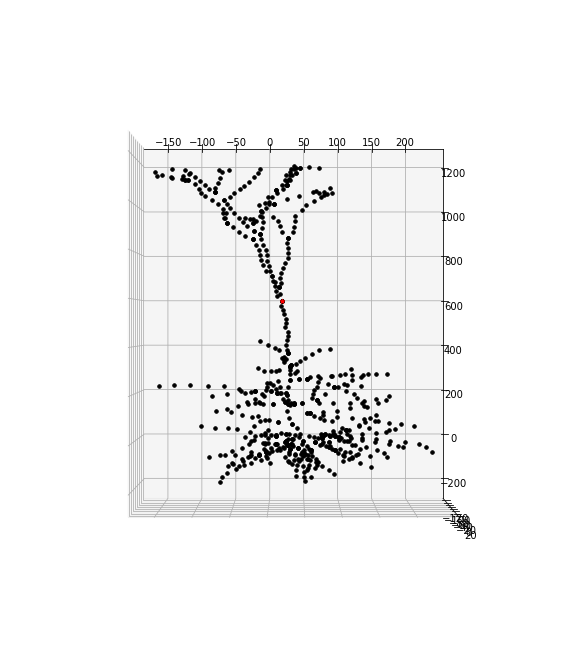

In [22]:
#3D Projection
elev=90 
azim=-90 #20
figsize=(10,12)
# apicsegs=segs[(segs.Type=='apic')]['segmentID']
#create 3d axes
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection='3d')
ax.plot3D(AllSegXCoord, AllSegYCoord,AllSegZCoord,'.',color='k',markersize=7)
# for i in range(len(AllSegXCoord)):
#   ax.scatter(AllSegXCoord[i], AllSegYCoord[i],AllSegZCoord[i],'.',color='k')

print(complex_segments[0].color)
# for i in range(len(probes)):
ax.scatter(xs=AllSegXCoord[complex_segments[firstsegs[-61]].parentprobe[0].seg],
        ys=AllSegYCoord[complex_segments[firstsegs[-61]].parentprobe[0].seg],
        zs=AllSegZCoord[complex_segments[firstsegs[-61]].parentprobe[0].seg],
        marker='*',color=complex_segments[complex_segments[firstsegs[-61]].parentprobe[0].seg].color)
plt.savefig('Probe Locations.png')
# ax.auto_scale_xyz(*box.T)
ax.view_init(elev,azim)
plt.show()

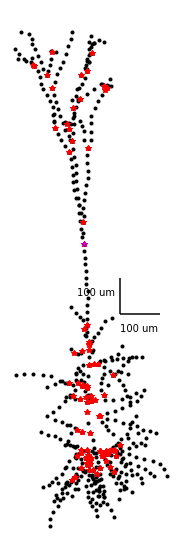

In [23]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

for i in firstsegs:
  if complex_segments[i].parentprobe != []:
    plt.plot(AllSegXCoord[complex_segments[i].parentprobe[0].seg],
          AllSegYCoord[complex_segments[i].parentprobe[0].seg],
          '*',color='red')
  # for j in range(len(probes[i].adjprobes)):
  #     plt.plot(AllSegXCoord[probes[i].adjprobes[j].seg],
  #         AllSegYCoord[probes[i].adjprobes[j].seg],
  #         '*',color='blue')

nexus=[complex_segments[firstsegs[-61]].parentprobe[0].seg] #check parentseg()'s by guessing where to index #segments[firstsegs[-51]].parentprobe[0].seg is a branching segment in the nexus following this first branching segment
# # adjp=[0] #indexes childprobes of nexus probes to find the adjacent
for i in nexus:
  plt.plot(AllSegXCoord[complex_segments[i].seg],
         AllSegYCoord[complex_segments[i].seg],
         '*',color='m')
  # see all adj probes
  # for j in range(len(probes[].adjprobes)):
  #   plt.plot(AllSegXCoord[probes[].adjprobes[j].seg],
  #       AllSegYCoord[probes[psegs[i]].adjprobes[j].seg],
  #       '*',color='blue')
#see child probes
  # for j in range(len(segments[i].childprobes)):
  #     plt.plot(AllSegXCoord[segments[i].childprobes[j].seg],
  #         AllSegYCoord[segments[i].childprobes[j].seg],
  #         '*',color='orange')
#see parent probes      
  # for j in range(len(probes[i].parentprobe)):
  #     plt.plot(AllSegXCoord[probes[i].parentprobe[j].seg],
  #         AllSegYCoord[probes[i].parentprobe[j].seg],
  #         '*',color='blue')

Simulate the full neuron for 1 seconds

In [25]:
soma_v = h.Vector()
soma_v.record(complex_cell.soma[0](0.5)._ref_v)

time_v = h.Vector()
time_v.record(h._ref_t)

h.tstop = 1000
st = time.time()
h.run()
print('complex cell simulation time {:.4f}'.format(time.time()-st))
complex_cell_v = list(soma_v)

complex cell simulation time 51.9590


Gather complex cell geometry

In [26]:
generate_stylized_geometry(cell=complex_cell,savename='geom_complex.csv')

apply Neuron_Reduce to simplify the cell and run the simulation again on the reduced cell

reduced cell simulation time 1.2090


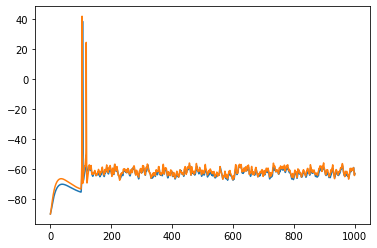

In [27]:
#apply Neuron_Reduce to simplify the cell
reduced_cell, synapses_list, netcons_list = neuron_reduce.subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0, total_segments_manual=-1)
for r in randoms_list:r.seq(1) #reset random


#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
reduced_celll_v = list(soma_v)

#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.show()

In [28]:
make_reduced_seg_df(reduced_cell,"segments_reduced.csv")

In [29]:
reduced_segments_df=pd.read_csv("segments_reduced.csv")

In [30]:
reduced_segments_df.head()

,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,Section_diam,Section_nseg,Section_Ra,ParentSegID,Passive ElecDist,Active ElecDist,Section Name
0,0,0,127.133115,3.717652,0.026316,apic,0,75.151262,2415.529185,3.717652,19,100.0,Segment not in segments,0.729871,0.733694,model[0].apic[0]
1,1,0,127.133115,3.717652,0.078947,apic,0,202.284376,2415.529185,3.717652,19,100.0,0,0.447482,0.451835,model[0].apic[0]
2,2,0,127.133115,3.717652,0.131579,apic,0,329.417491,2415.529185,3.717652,19,100.0,1,0.238126,0.240671,model[0].apic[0]
3,3,0,127.133115,3.717652,0.184211,apic,0,456.550606,2415.529185,3.717652,19,100.0,2,0.134906,0.136294,model[0].apic[0]
4,4,0,127.133115,3.717652,0.236842,apic,0,583.683721,2415.529185,3.717652,19,100.0,3,0.082859,0.083650,model[0].apic[0]


In [35]:
#Get Columns
segIDs=reduced_segments_df['segmentID']

# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index() #not sure what this does
reduced_segments_df['Sec ID'] = reduced_segments_df['Sec ID'].astype(int)
reduced_segments_df['X'] = reduced_segments_df['X'].astype(float)
reduced_segments_df['Elec_distanceQ'] = 'None'
# AllSegXCoord=reduced_segments_df['Coord X']
# AllSegYCoord=reduced_segments_df['Coord Y']
# AllSegZCoord=reduced_segments_df['Coord Z']
AllSegSec_ID=reduced_segments_df['Sec ID']
AllSegSec_name=reduced_segments_df['Type']
segLs=reduced_segments_df["Seg_L"]
segxs=reduced_segments_df["X"]
segdists=reduced_segments_df["Distance"]
SegSecL=reduced_segments_df["Section_L"]
segdiams=reduced_segments_df["Seg_diam"]
SegSecnseg=reduced_segments_df["Section_nseg"]
secRas=reduced_segments_df["Section_Ra"]
psegIDs=reduced_segments_df["ParentSegID"]
secids=reduced_segments_df["Sec ID"]
bmtkid=reduced_segments_df["BMTK ID"]
sectypes=reduced_segments_df["Type"]
reduced_passive_elec_dists=reduced_segments_df["Passive ElecDist"]
reduced_active_elec_dists=reduced_segments_df["Active ElecDist"]

psegids=[] #fix for when there is no parent segment
# for i in range(len(psegIDs)):
#   if np.isnan(psegIDs[i]) == False:
#     psegids.append(int(psegIDs[i]))
#   else:
#     psegids.append(psegIDs[i])

reduced_segments=[] #list for probe objects

for i in range(len(reduced_segments_df['segmentID'])):
  try:
    newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color=colors[j],XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                  secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                  sectype=sectypes[i],passive_elec_dist=reduced_passive_elec_dists[i],active_elec_dist=reduced_active_elec_dists[i])
  except: #use red if colors isn't long enough
        newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color='r',XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
               sectype=sectypes[i],passive_elec_dist=reduced_passive_elec_dists[i],active_elec_dist=reduced_active_elec_dists[i])
  reduced_segments.append(newprobe)

In [ ]:
dir(reduced_segments[3])

In [36]:
#Find equivalent passive elec_dist
passive_elec_dist_to_nexus=complex_segments[nexus[0]].passive_elec_dist #Complex cell nexus electrotonic distance
print("Complex Cell's electrotonic distance to nexus branching segment:",passive_elec_dist_to_nexus)
print("Electrotonic distance to each segment in the reduced apical cylinder:")
for i in range(len(reduced_segments)):
  if reduced_segments[i].sectype=="apic":
    print(reduced_segments[i].passive_elec_dist)
    if reduced_segments[i].passive_elec_dist==passive_elec_dist_to_nexus:
      print("This is segment with equivalent elec distance",i)

Complex Cell's electrotonic distance to nexus branching segment: 0.4901355173781123
Electrotonic distance to each segment in the reduced apical cylinder:
0.7298711452706049
0.4474817206037379
0.2381255422965062
0.134906426285836
0.0828594809809623
0.0581384590379483
0.0411705315903188
0.0294649806365547
0.0203635592258771
0.0142351031846877
0.0103764493475629
0.0077373560681378
0.0059944025739695
0.0046649937787361
0.003665987976773
0.0026467656270667
0.001849473211183
0.0013562919955331
0.0010493796717602


In [41]:
#Find equivalent elec_dist
#active
passive_elec_dist_to_nexus=complex_segments[nexus[0]].passive_elec_dist #Complex cell nexus electrotonic distance
print("Complex Cell's electrotonic distance to nexus branching segment:",passive_elec_dist_to_nexus)
print("Minimum passive electrotonic distance|complex:",min(complex_passive_elec_dists),"|reduced:",min(reduced_passive_elec_dists))
print()
#active
active_elec_dist_to_nexus=complex_segments[nexus[0]].active_elec_dist #Complex cell nexus electrotonic distance
print("Complex Cell's electrotonic distance to nexus branching segment:",active_elec_dist_to_nexus)
print("Minimum active electrotonic distance|complex:",min(complex_active_elec_dists),"|reduced:",min(reduced_active_elec_dists))
def find_matching_apical_elec_dist(reduced_segments,channels='Passive'):
  if channels=='Passive':
    for i,reduced_seg in enumerate(reduced_segments):
      if reduced_seg.sectype=="apic":
        # print(reduced_seg.passive_elec_dist)
        if reduced_seg.passive_elec_dist<passive_elec_dist_to_nexus:
          return i
  else:
    for i,reduced_seg in enumerate(reduced_segments):
      if reduced_seg.sectype=="apic":
        # print(reduced_seg.active_elec_dist)
        if reduced_seg.active_elec_dist<active_elec_dist_to_nexus:
          return i
print()
i=find_matching_apical_elec_dist(reduced_segments,channels="Active")
print("This is the reduced segment index matching active_elec_dist_to_nexus",i,"|Reduced Elec Dist",reduced_segments[i].active_elec_dist,"|Complex Elec Dist:",active_elec_dist_to_nexus)
i=find_matching_apical_elec_dist(reduced_segments,channels="Passive")
print("This is the reduced segment index matching passive_elec_dist_to_nexus",i,"|Reduced Elec Dist",reduced_segments[i].passive_elec_dist,"|Complex Elec Dist:",passive_elec_dist_to_nexus)

Complex Cell's electrotonic distance to nexus branching segment: 0.4901355173781123
Minimum passive electrotonic distance|complex: 0.0088797589888252 |reduced: 0.0010493796717602

Complex Cell's electrotonic distance to nexus branching segment: 0.4022223254102383
Minimum active electrotonic distance|complex: 0.0023311422681292 |reduced: 0.0007976683341002

This is the reduced segment index matching active_elec_dist_to_nexus 2 |Reduced Elec Dist 0.2406708611076727 |Complex Elec Dist: 0.4022223254102383
This is the reduced segment index matching passive_elec_dist_to_nexus 1 |Reduced Elec Dist 0.4474817206037379 |Complex Elec Dist: 0.4901355173781123


In [ ]:
print(complex_segments)

In [ ]:
dir(reduced_cell)

In [ ]:
generate_reduced_stylized_geometry(reduced_cell=reduced_cell)

In [ ]:
# work in progress #currently mostly pseudo-code
#Would alter the geometry file for the stylized module, but we are no longer using stylized module.
def Create_Equivalent_Tree_From_Cylinder(trunk_section):
  '''
  alters the geometry_file.csv so that a cylindrical section turns into a trunk with branches.
  '''
  #needs to pull radii and lengths of new sections from other functions
  L_trunk=calc_branch_point(trunk_section)
  R_trunk=trunk_section.diam/2
  #L_branch=calc_branch_L
  #R_branch=

  

def calc_branch_point(complex_trunk_section,reduced_section_geometry):
  '''
  calculates the length (um) at which the equivalent cylinder should start to branch
  '''
  #needs to convert initial trunk section to the same parameter space as the equivalent cylinder
  #equivalent cylinder length is not equivalent to complex cell length. Branch point should occur at the same elctrotonic distance
  #Find electrotonic distance at branch point.
  Ri=complex_trunk_section.Ri
  Rm=complex_trunk_section.Rm
  Cm=complex_trunk_section.Cm
  Diam=complex_trunk_section.Diam
  max_L=calc_electrotonic_length(complex_trunk_section) # calculate the electrotonic distance at the end of this trunk section
  Length=calc_eqcyl_length(max_L) #get the  equivalent reduced cylinder's real length that corresponds to this electrotonic distance
  return Length

def calc_eqcyl_length(complex_electrotonic_length,reduced_diam):
  '''
  calculates the length of the equivalent reduced cylinder 
  that corresponds to the inputted electrotonic length
  '''


def calc_electrotonic_length(trunk_length,trunk_Rm,trunk_Cm,trunk_Ri,trunk_diam):
  '''
  calculate the electrotonic length of the complex trunk section
  '''
  elec_L=trunk_L/np.sqrt(trunk_Rm*trunk_Cm/(trunk_Ri/np.pi*(trunk_diam^2)/4))
  return elec_L

##Determine Electrotonic Distance from soma to nexus

Check Surface Area

In [ ]:
# check surface area
def calc_cyl_SA(L,R):
  '''
  calculate surface area of a cylinder : 2πrh+2πr2
  '''
  wrap_SA = 2*np.pi*R*L
  circles_SA = 2*np.pi*R*2 #may not want to include circle_SA
  total_SA= wrap_SA + circles_SA
  return wrap_SA, circles_SA, total_SA

def calc_model_SA(geom_file='geom_complex.csv',omit_soma=False):
  df=pd.read_csv(geom_file)
  Ls=df['L']
  Rs=df['R']
  total_wrap_SA=0
  total_circles_SA=0
  total_total_SA=0
  if omit_soma == False:
    for i in range(len(Ls)): # add all surface area
      wrap_SA, circles_SA, total_SA = calc_cyl_SA(L=Ls[i],R=Rs[i])
      total_wrap_SA += wrap_SA #surface area not including the circle surfaces
      total_total_SA += total_SA
  else: # omit soma case, should skip first entry in geometry file
    for i in range(len(Ls)-1): 
      wrap_SA, circles_SA, total_SA = calc_cyl_SA(L=Ls[i+1],R=Rs[i+1]) 
      total_wrap_SA += wrap_SA #surface area not including the circle surfaces
      total_total_SA += total_SA
  return total_total_SA, total_wrap_SA

complex_total_SA,complex_wrap_SA=calc_model_SA('geom_complex.csv')
reduced_total_SA,reduced_wrap_SA=calc_model_SA('geom_reduced.csv')

print('Complex model surface area:',complex_total_SA,)
print('Reduced model surface area:',reduced_total_SA,)
print('Difference:',complex_total_SA-reduced_total_SA)

#Show Complex and Reduced Cell

#Reducing a Stylized Cell

# Reducing a L5PC model with more biophysically realistic synaptic input.

# Citation
O. Amsalem, G. Eyal, N. Rogozinski, M. Gevaert, P. Kumbhar, F. Schürmann, I. Segev. An efficient analytical reduction of detailed nonlinear neuron models. Nat. Commun., 11 (2020), p. 288